In [2]:
import os
os.environ["WANDB_API_KEY"] = "dcf9600e0485401cbb0ddbb0f7be1c70f96b32ef"
os.environ["WANDB_MODE"] = "disabled"
import argparse
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import ipdb
import wandb
from sigma_layer import SigmaLinear, SigmaConv, SigmaView
from utils import get_dataset, gradient_centralization, normalize_along_axis, get_activation_function, compute_SCL_loss
import datetime

In [16]:
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
# Training scheme group
method_parser = parser.add_argument_group("Method")
method_parser.add_argument('--method', type=str, default='SIGMA', choices=['SIGMA', 'BP', 'FA'])
method_parser.add_argument('--actfunc', type=str, default='elu', choices=['tanh', 'elu', 'relu'])
method_parser.add_argument('--conv_dim', type=int, default=64, choices=[32, 64])
# Dataset group
dataset_parser = parser.add_argument_group('Dataset')
dataset_parser.add_argument('--dataset', type=str, default='MNIST', choices=['MNIST', 'CIFAR10'])
dataset_parser.add_argument('--batchsize', type=int, default=64)
dataset_parser.add_argument('--splitratio', type=float, default=0.2)
# Training group # LR, optimizer, weight_decay, momentum
training_parser = parser.add_argument_group('Training')
training_parser.add_argument('--epochs', type=int, default=100)
training_parser.add_argument('--lr', type=float, default=1)
training_parser.add_argument('--optimizer', type=str, default='SGD', choices=['RMSprop', 'Adam', 'SGD'])
# Seed group
seed_parser = parser.add_argument_group('Seed')
seed_parser.add_argument('--seed', type=int, default=2023)
args, _ = parser.parse_known_args()

# Set run_name
run_name = f"{args.dataset}_{args.method}_conv{args.conv_dim}-act{args.actfunc}_{args.optimizer}_{args.lr}_{args.seed}"
time_stamp = datetime.datetime.now().strftime("%m-%d_%H-%M-%S")

# Set wandb
wandb.init(
    project="opt-sigma",
    name=run_name,
    # track hyperparameters and run metadata
    config={
    "algorithm": args.method,
    "architecture": "SimpleCNN",
    "dataset": args.dataset,
    "epochs": args.epochs,
    "lr": args.lr,
    "optimizer": args.optimizer,
    "seed": args.seed,
    "conv_dim": args.conv_dim,
    "actfunc": args.actfunc,
    }
)

print(f"Run name: {run_name}")

# Set seed
torch.manual_seed(args.seed), np.random.seed(args.seed)

# Set device
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")

# Get dataset
train_loader, val_loader, test_loader = get_dataset(args)

class SigmaModel_SimpleCNN(nn.Module):
    def __init__(self, args):
        super(SigmaModel_SimpleCNN, self).__init__()
        self.LN1 = torch.nn.LayerNorm((1,28,28), elementwise_affine=False) 
        self.LN2 = torch.nn.LayerNorm((args.conv_dim,14,14), elementwise_affine=False) 
        self.conv1 = SigmaConv(1, args.conv_dim, 3, args)
        self.conv2 = SigmaConv(args.conv_dim, 64, 3, args)
        self.view1 = SigmaView((64, 7, 7), 64 * 7 * 7)
        self.fc1 = SigmaLinear(64 * 7 * 7, 128, args)
        self.fc2 = SigmaLinear(128, 10, args)
                
        self.forward_params = list()
        self.backward_params = list()
        for layer in [self.conv1, self.conv2, self.fc1, self.fc2]:
            forward_params, backward_params = layer.get_parameters()
            self.forward_params += forward_params
            self.backward_params += backward_params

    def forward(self, x, detach_grad=False, return_activations=True):   
        # x = self.LN1(x)
        a1 = self.conv1(x, detach_grad)
        a2 = self.conv2(a1, detach_grad)
        a2 = self.view1(a2, detach_grad)
        a3 = self.fc1(a2, detach_grad)
        a4 = self.fc2(a3, detach_grad)
        return [a1, a2, a3, a4]
        
    def reverse(self, target, detach_grad=True, return_activations=True):
        if target.shape == torch.Size([10]): 
            target = F.one_hot(target, num_classes=10).float().to(target.device)
        
        b3 = self.fc2.reverse(target, detach_grad)
        b2 = self.fc1.reverse(b3, detach_grad)
        b2 = self.view1.reverse(b2, detach_grad)
        b1 = self.conv2.reverse(b2, detach_grad)
        return [b1, b2, b3, target]


class SigmaLoss(nn.Module):
    def __init__(self, args):
        super(SigmaLoss, self).__init__()
        self.args = args
        self.final_criteria = nn.CrossEntropyLoss()
        self.local_criteria = compute_SCL_loss
        self.method = args.method
        
    def forward(self, activations, signals, target, method="final"):
        """
        Activations and signals are list of activations
        target is a onehot representation of target sigals
        """
        if method == "local":
            loss = list()
            for act, sig in zip(activations[:-1], signals[:-1]):
                loss += [self.local_criteria(act, sig, target)]
            loss += [self.final_criteria(activations[-1], target)]
            return sum(loss), loss[-1].item()
        elif method == "final":
            loss = self.final_criteria(activations[-1], target)
            return loss, loss.item()
        
model = SigmaModel_SimpleCNN(args)
model.to(device)
if args.optimizer == "SGD": 
    forward_optimizer = optim.SGD(model.forward_params, lr=args.lr)
    backward_optimizer = optim.SGD(model.forward_params, lr=args.lr)
elif args.optimizer == "RMSprop": forward_optimizer = optim.RMSprop(model.forward_params, lr=args.lr, weight_decay=0)
elif args.optimizer == "Adam": forward_optimizer = optim.Adam(model.forward_params, lr=args.lr)
criteria = SigmaLoss(args)
    
with torch.no_grad():
    signals = model.reverse(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device), return_activations=True)
    
best_val_loss = float('inf')

print("No LN1")
for epoch in tqdm(range(args.epochs)):
    
    train_loss, train_counter = 0, 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        if args.method == "SIGMA":
            activations = model(data.to(device), detach_grad=True)
            # signals = model.reverse(torch.Tensor([0,1,2,3,4,5,6,7,8,9]).long().to(device), detach_grad=True)
            loss, loss_item = criteria(activations, signals, target.to(device), method="local")
        elif args.method == "BP":
            activations = model(data.to(device), detach_grad=False)
            loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        forward_optimizer.zero_grad(), backward_optimizer.zero_grad(), loss.backward()
        gradient_centralization(model), forward_optimizer.step(), backward_optimizer.step()
        train_loss += loss_item * len(data)
        train_counter += len(data)

    wandb.log({'train_loss': train_loss / train_counter}, step=epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx > 100: continue
        activations = model(data.to(device), detach_grad=True)
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        forward_optimizer.zero_grad(), loss.backward(), forward_optimizer.step()

    # Validation
    val_correct, val_loss, val_counter = 0, 0, 0
    with torch.no_grad():
        for data, target in val_loader:
            val_counter += len(data)
            if args.method == "SIGMA":
                activations = model(data.to(device), detach_grad=True)
                _, loss_item = criteria(activations, signals, target.to(device), method="local")
                
            elif args.method == "BP":
                activations = model(data.to(device), detach_grad=True)
                _, loss_item = criteria(activations, signals, target.to(device), method="final")
            prediction = activations[-1].detach()
            _, predicted = torch.max(prediction, 1)
            val_correct += (predicted == target.to(device)).sum().item()
            val_loss += loss_item * len(data)

    wandb.log({'val_loss': val_loss / val_counter, 
               'val_acc': val_correct / val_counter, 
               }, step=epoch)
    
    print(f"""Epoch {epoch} | train loss {train_loss / train_counter:.4f} | val loss {val_loss / val_counter:.4f} | val acc {100 * val_correct / val_counter:.4f}""")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), f'./saved_models/{run_name}-{time_stamp}.pt')
        

# Eval on Test Set by loading the best model 
model.load_state_dict(torch.load(f'./saved_models/{run_name}-{time_stamp}.pt'))
model.eval()
correct, total = 0, 0
test_loss, test_counter = 0, 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data.to(device), detach_grad=False)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == target.to(device)).sum().item()
        loss, loss_item = criteria(activations, signals, target.to(device), method="final")
        test_loss += loss_item * len(data)
        test_counter += len(data)

wandb.log({'test_loss': test_loss / test_counter,
           'test_acc': 100 * correct / test_counter})

print(f'Epoch: {epoch}, Test Accuracy: {100 * correct / test_counter:.4f}%')

Run name: MNIST_SIGMA_conv64-actelu_SGD_1_2023
No LN1


  1%|▍                                          | 1/100 [00:11<19:03, 11.55s/it]

Epoch 0 | train loss 1.8840 | val loss 0.9024 | val acc 66.1167


  2%|▊                                          | 2/100 [00:22<18:35, 11.38s/it]

Epoch 1 | train loss 0.6396 | val loss 0.1537 | val acc 95.8000


  3%|█▎                                         | 3/100 [00:33<18:13, 11.27s/it]

Epoch 2 | train loss 0.1555 | val loss 0.1124 | val acc 96.5417


  4%|█▋                                         | 4/100 [00:45<17:53, 11.19s/it]

Epoch 3 | train loss 0.1155 | val loss 0.0968 | val acc 96.9167


  5%|██▏                                        | 5/100 [00:55<17:33, 11.09s/it]

Epoch 4 | train loss 0.0993 | val loss 0.0910 | val acc 97.2500


  6%|██▌                                        | 6/100 [01:07<17:22, 11.09s/it]

Epoch 5 | train loss 0.0943 | val loss 0.0855 | val acc 97.3417


  7%|███                                        | 7/100 [01:17<17:07, 11.05s/it]

Epoch 6 | train loss 0.0825 | val loss 0.0846 | val acc 97.4500


  8%|███▍                                       | 8/100 [01:28<16:47, 10.95s/it]

Epoch 7 | train loss 0.0815 | val loss 0.0828 | val acc 97.4333


  9%|███▊                                       | 9/100 [01:39<16:30, 10.88s/it]

Epoch 8 | train loss 0.0731 | val loss 0.0782 | val acc 97.6083


 10%|████▏                                     | 10/100 [01:50<16:19, 10.89s/it]

Epoch 9 | train loss 0.0784 | val loss 0.0759 | val acc 97.7083


 11%|████▌                                     | 11/100 [02:01<16:13, 10.93s/it]

Epoch 10 | train loss 0.0685 | val loss 0.0731 | val acc 97.7583


 12%|█████                                     | 12/100 [02:12<16:08, 11.00s/it]

Epoch 11 | train loss 0.0768 | val loss 0.0714 | val acc 97.8833


 13%|█████▍                                    | 13/100 [02:23<15:53, 10.96s/it]

Epoch 12 | train loss 0.0652 | val loss 0.0711 | val acc 97.7917


 14%|█████▉                                    | 14/100 [02:34<15:44, 10.99s/it]

Epoch 13 | train loss 0.0601 | val loss 0.0691 | val acc 97.8583


 15%|██████▎                                   | 15/100 [02:45<15:34, 11.00s/it]

Epoch 14 | train loss 0.0562 | val loss 0.0672 | val acc 97.9833


 16%|██████▋                                   | 16/100 [02:56<15:21, 10.97s/it]

Epoch 15 | train loss 0.0595 | val loss 0.0631 | val acc 97.9500


 17%|███████▏                                  | 17/100 [03:07<15:11, 10.98s/it]

Epoch 16 | train loss 0.0524 | val loss 0.0643 | val acc 97.9833


 18%|███████▌                                  | 18/100 [03:17<14:49, 10.84s/it]

Epoch 17 | train loss 0.0601 | val loss 0.0633 | val acc 97.9833


 19%|███████▉                                  | 19/100 [03:28<14:34, 10.79s/it]

Epoch 18 | train loss 0.0607 | val loss 0.0637 | val acc 97.9833


 20%|████████▍                                 | 20/100 [03:39<14:18, 10.73s/it]

Epoch 19 | train loss 0.0572 | val loss 0.0629 | val acc 98.0333


 21%|████████▊                                 | 21/100 [03:49<14:07, 10.73s/it]

Epoch 20 | train loss 0.0643 | val loss 0.0621 | val acc 98.1000


 22%|█████████▏                                | 22/100 [04:00<14:01, 10.79s/it]

Epoch 21 | train loss 0.0553 | val loss 0.0638 | val acc 98.0333


 23%|█████████▋                                | 23/100 [04:11<13:56, 10.86s/it]

Epoch 22 | train loss 0.0572 | val loss 0.0601 | val acc 98.2250


 24%|██████████                                | 24/100 [04:22<13:51, 10.94s/it]

Epoch 23 | train loss 0.0581 | val loss 0.0579 | val acc 98.2417


 25%|██████████▌                               | 25/100 [04:34<13:43, 10.98s/it]

Epoch 24 | train loss 0.0448 | val loss 0.0584 | val acc 98.2333


 26%|██████████▉                               | 26/100 [04:45<13:32, 10.99s/it]

Epoch 25 | train loss 0.0492 | val loss 0.0568 | val acc 98.2917


 27%|███████████▎                              | 27/100 [04:56<13:21, 10.98s/it]

Epoch 26 | train loss 0.0434 | val loss 0.0576 | val acc 98.2583


 28%|███████████▊                              | 28/100 [05:07<13:10, 10.98s/it]

Epoch 27 | train loss 0.0489 | val loss 0.0573 | val acc 98.2167


 29%|████████████▏                             | 29/100 [05:18<13:03, 11.03s/it]

Epoch 28 | train loss 0.0523 | val loss 0.0550 | val acc 98.2583


 30%|████████████▌                             | 30/100 [05:29<13:01, 11.16s/it]

Epoch 29 | train loss 0.0494 | val loss 0.0553 | val acc 98.3000


 31%|█████████████                             | 31/100 [05:40<12:47, 11.13s/it]

Epoch 30 | train loss 0.0480 | val loss 0.0544 | val acc 98.2917


 32%|█████████████▍                            | 32/100 [05:52<12:41, 11.20s/it]

Epoch 31 | train loss 0.0510 | val loss 0.0550 | val acc 98.3250


 33%|█████████████▊                            | 33/100 [06:03<12:25, 11.13s/it]

Epoch 32 | train loss 0.0448 | val loss 0.0543 | val acc 98.3250


 34%|██████████████▎                           | 34/100 [06:13<12:09, 11.05s/it]

Epoch 33 | train loss 0.0391 | val loss 0.0545 | val acc 98.3250


 35%|██████████████▋                           | 35/100 [06:24<11:45, 10.86s/it]

Epoch 34 | train loss 0.0415 | val loss 0.0575 | val acc 98.1583


 36%|███████████████                           | 36/100 [06:34<11:25, 10.71s/it]

Epoch 35 | train loss 0.0459 | val loss 0.0537 | val acc 98.3250


 37%|███████████████▌                          | 37/100 [06:45<11:22, 10.84s/it]

Epoch 36 | train loss 0.0404 | val loss 0.0525 | val acc 98.4417


 38%|███████████████▉                          | 38/100 [06:56<11:18, 10.94s/it]

Epoch 37 | train loss 0.0466 | val loss 0.0537 | val acc 98.3500


 39%|████████████████▍                         | 39/100 [07:07<11:05, 10.91s/it]

Epoch 38 | train loss 0.0444 | val loss 0.0511 | val acc 98.4083


 40%|████████████████▊                         | 40/100 [07:18<10:56, 10.94s/it]

Epoch 39 | train loss 0.0445 | val loss 0.0528 | val acc 98.3250


 41%|█████████████████▏                        | 41/100 [07:29<10:41, 10.88s/it]

Epoch 40 | train loss 0.0482 | val loss 0.0522 | val acc 98.3667


 42%|█████████████████▋                        | 42/100 [07:40<10:37, 10.99s/it]

Epoch 41 | train loss 0.0417 | val loss 0.0517 | val acc 98.4333


 43%|██████████████████                        | 43/100 [07:51<10:27, 11.02s/it]

Epoch 42 | train loss 0.0398 | val loss 0.0519 | val acc 98.4667


 44%|██████████████████▍                       | 44/100 [08:03<10:26, 11.18s/it]

Epoch 43 | train loss 0.0433 | val loss 0.0524 | val acc 98.3750


 45%|██████████████████▉                       | 45/100 [08:14<10:19, 11.27s/it]

Epoch 44 | train loss 0.0388 | val loss 0.0534 | val acc 98.3583


 46%|███████████████████▎                      | 46/100 [08:27<10:23, 11.54s/it]

Epoch 45 | train loss 0.0418 | val loss 0.0503 | val acc 98.4833


 47%|███████████████████▋                      | 47/100 [08:39<10:20, 11.72s/it]

Epoch 46 | train loss 0.0399 | val loss 0.0530 | val acc 98.3917


 48%|████████████████████▏                     | 48/100 [08:49<09:52, 11.39s/it]

Epoch 47 | train loss 0.0488 | val loss 0.0490 | val acc 98.5083


 49%|████████████████████▌                     | 49/100 [09:00<09:34, 11.26s/it]

Epoch 48 | train loss 0.0443 | val loss 0.0518 | val acc 98.4417


 50%|█████████████████████                     | 50/100 [09:11<09:17, 11.15s/it]

Epoch 49 | train loss 0.0375 | val loss 0.0526 | val acc 98.4000


 51%|█████████████████████▍                    | 51/100 [09:22<09:02, 11.07s/it]

Epoch 50 | train loss 0.0352 | val loss 0.0505 | val acc 98.4750


 52%|█████████████████████▊                    | 52/100 [09:33<08:47, 11.00s/it]

Epoch 51 | train loss 0.0456 | val loss 0.0508 | val acc 98.3417


 53%|██████████████████████▎                   | 53/100 [09:44<08:42, 11.11s/it]

Epoch 52 | train loss 0.0330 | val loss 0.0515 | val acc 98.4583


 54%|██████████████████████▋                   | 54/100 [09:56<08:36, 11.23s/it]

Epoch 53 | train loss 0.0383 | val loss 0.0512 | val acc 98.4750


 55%|███████████████████████                   | 55/100 [10:07<08:24, 11.21s/it]

Epoch 54 | train loss 0.0450 | val loss 0.0523 | val acc 98.4417


 56%|███████████████████████▌                  | 56/100 [10:18<08:13, 11.21s/it]

Epoch 55 | train loss 0.0300 | val loss 0.0514 | val acc 98.4417


 57%|███████████████████████▉                  | 57/100 [10:29<07:59, 11.15s/it]

Epoch 56 | train loss 0.0426 | val loss 0.0515 | val acc 98.4167


 58%|████████████████████████▎                 | 58/100 [10:40<07:47, 11.14s/it]

Epoch 57 | train loss 0.0321 | val loss 0.0507 | val acc 98.4750


 59%|████████████████████████▊                 | 59/100 [10:51<07:31, 11.02s/it]

Epoch 58 | train loss 0.0354 | val loss 0.0534 | val acc 98.3667


 60%|█████████████████████████▏                | 60/100 [11:02<07:19, 10.99s/it]

Epoch 59 | train loss 0.0400 | val loss 0.0524 | val acc 98.3333


 61%|█████████████████████████▌                | 61/100 [11:13<07:06, 10.94s/it]

Epoch 60 | train loss 0.0366 | val loss 0.0516 | val acc 98.4083


 62%|██████████████████████████                | 62/100 [11:25<07:05, 11.19s/it]

Epoch 61 | train loss 0.0405 | val loss 0.0505 | val acc 98.4917


 63%|██████████████████████████▍               | 63/100 [11:37<07:02, 11.42s/it]

Epoch 62 | train loss 0.0329 | val loss 0.0504 | val acc 98.4333


 64%|██████████████████████████▉               | 64/100 [11:47<06:45, 11.26s/it]

Epoch 63 | train loss 0.0394 | val loss 0.0514 | val acc 98.4417


 65%|███████████████████████████▎              | 65/100 [11:58<06:29, 11.13s/it]

Epoch 64 | train loss 0.0361 | val loss 0.0518 | val acc 98.4000


 66%|███████████████████████████▋              | 66/100 [12:09<06:18, 11.14s/it]

Epoch 65 | train loss 0.0338 | val loss 0.0532 | val acc 98.4250


 67%|████████████████████████████▏             | 67/100 [12:21<06:08, 11.17s/it]

Epoch 66 | train loss 0.0398 | val loss 0.0512 | val acc 98.4583


 68%|████████████████████████████▌             | 68/100 [12:32<05:57, 11.17s/it]

Epoch 67 | train loss 0.0471 | val loss 0.0524 | val acc 98.4167


 69%|████████████████████████████▉             | 69/100 [12:43<05:46, 11.17s/it]

Epoch 68 | train loss 0.0313 | val loss 0.0517 | val acc 98.4833


 70%|█████████████████████████████▍            | 70/100 [12:55<05:41, 11.38s/it]

Epoch 69 | train loss 0.0362 | val loss 0.0526 | val acc 98.4750


 71%|█████████████████████████████▊            | 71/100 [13:06<05:24, 11.20s/it]

Epoch 70 | train loss 0.0348 | val loss 0.0511 | val acc 98.4167


 72%|██████████████████████████████▏           | 72/100 [13:16<05:08, 11.03s/it]

Epoch 71 | train loss 0.0321 | val loss 0.0504 | val acc 98.5000


 73%|██████████████████████████████▋           | 73/100 [13:27<04:54, 10.89s/it]

Epoch 72 | train loss 0.0357 | val loss 0.0512 | val acc 98.4583


 74%|███████████████████████████████           | 74/100 [13:38<04:42, 10.88s/it]

Epoch 73 | train loss 0.0284 | val loss 0.0509 | val acc 98.3917


 75%|███████████████████████████████▌          | 75/100 [13:49<04:37, 11.11s/it]

Epoch 74 | train loss 0.0321 | val loss 0.0513 | val acc 98.5333


 76%|███████████████████████████████▉          | 76/100 [14:00<04:25, 11.08s/it]

Epoch 75 | train loss 0.0278 | val loss 0.0514 | val acc 98.4583


 77%|████████████████████████████████▎         | 77/100 [14:11<04:15, 11.09s/it]

Epoch 76 | train loss 0.0286 | val loss 0.0506 | val acc 98.4667


 78%|████████████████████████████████▊         | 78/100 [14:22<04:03, 11.07s/it]

Epoch 77 | train loss 0.0315 | val loss 0.0533 | val acc 98.3417


 79%|█████████████████████████████████▏        | 79/100 [14:34<03:52, 11.06s/it]

Epoch 78 | train loss 0.0339 | val loss 0.0517 | val acc 98.4333


 80%|█████████████████████████████████▌        | 80/100 [14:45<03:41, 11.07s/it]

Epoch 79 | train loss 0.0317 | val loss 0.0499 | val acc 98.4917


 81%|██████████████████████████████████        | 81/100 [14:56<03:30, 11.10s/it]

Epoch 80 | train loss 0.0362 | val loss 0.0507 | val acc 98.4583


 82%|██████████████████████████████████▍       | 82/100 [15:08<03:28, 11.57s/it]

Epoch 81 | train loss 0.0369 | val loss 0.0501 | val acc 98.5250


 83%|██████████████████████████████████▊       | 83/100 [15:19<03:13, 11.37s/it]

Epoch 82 | train loss 0.0335 | val loss 0.0490 | val acc 98.5583


 84%|███████████████████████████████████▎      | 84/100 [15:31<03:01, 11.35s/it]

Epoch 83 | train loss 0.0322 | val loss 0.0507 | val acc 98.4583


 85%|███████████████████████████████████▋      | 85/100 [15:42<02:49, 11.29s/it]

Epoch 84 | train loss 0.0310 | val loss 0.0484 | val acc 98.5917


 86%|████████████████████████████████████      | 86/100 [15:53<02:37, 11.25s/it]

Epoch 85 | train loss 0.0299 | val loss 0.0481 | val acc 98.5917


 87%|████████████████████████████████████▌     | 87/100 [16:04<02:26, 11.24s/it]

Epoch 86 | train loss 0.0319 | val loss 0.0512 | val acc 98.4583


 88%|████████████████████████████████████▉     | 88/100 [16:15<02:15, 11.27s/it]

Epoch 87 | train loss 0.0309 | val loss 0.0507 | val acc 98.5000


 89%|█████████████████████████████████████▍    | 89/100 [16:26<02:03, 11.19s/it]

Epoch 88 | train loss 0.0308 | val loss 0.0505 | val acc 98.4750


 90%|█████████████████████████████████████▊    | 90/100 [16:37<01:50, 11.06s/it]

Epoch 89 | train loss 0.0337 | val loss 0.0501 | val acc 98.5417


 91%|██████████████████████████████████████▏   | 91/100 [16:48<01:39, 11.03s/it]

Epoch 90 | train loss 0.0382 | val loss 0.0534 | val acc 98.3417


 92%|██████████████████████████████████████▋   | 92/100 [16:59<01:27, 10.95s/it]

Epoch 91 | train loss 0.0366 | val loss 0.0486 | val acc 98.4833


 93%|███████████████████████████████████████   | 93/100 [17:10<01:16, 10.96s/it]

Epoch 92 | train loss 0.0375 | val loss 0.0513 | val acc 98.4000


 94%|███████████████████████████████████████▍  | 94/100 [17:21<01:06, 11.03s/it]

Epoch 93 | train loss 0.0280 | val loss 0.0538 | val acc 98.3583


 95%|███████████████████████████████████████▉  | 95/100 [17:32<00:55, 11.02s/it]

Epoch 94 | train loss 0.0338 | val loss 0.0489 | val acc 98.5167


 96%|████████████████████████████████████████▎ | 96/100 [17:43<00:43, 10.89s/it]

Epoch 95 | train loss 0.0311 | val loss 0.0493 | val acc 98.5500


 97%|████████████████████████████████████████▋ | 97/100 [17:53<00:32, 10.81s/it]

Epoch 96 | train loss 0.0281 | val loss 0.0500 | val acc 98.5167


 98%|█████████████████████████████████████████▏| 98/100 [18:04<00:21, 10.76s/it]

Epoch 97 | train loss 0.0247 | val loss 0.0493 | val acc 98.5750


 99%|█████████████████████████████████████████▌| 99/100 [18:15<00:10, 10.85s/it]

Epoch 98 | train loss 0.0274 | val loss 0.0479 | val acc 98.5417


100%|█████████████████████████████████████████| 100/100 [18:26<00:00, 11.07s/it]

Epoch 99 | train loss 0.0245 | val loss 0.0520 | val acc 98.4750


AttributeError: 'list' object has no attribute 'data'

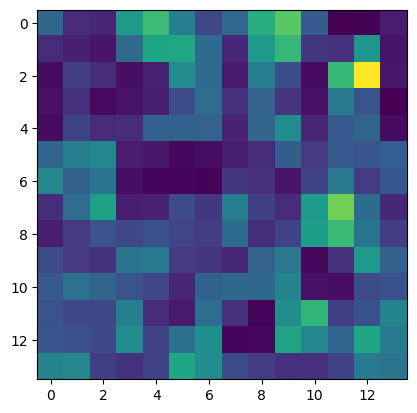

In [15]:
M = signals[0].detach().cpu().numpy()
plt.imshow(M[5,5])